In [6]:
import json
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import pad_sequences
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.layers import Masking
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
import numpy as np
from keras.models import Model
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D, Dense, Dropout, Masking, Input, Bidirectional
from keras.regularizers import l2
import tensorflow as tf
import sys

features_d1 = []
labels_d1 = []
labels_domain = []
features_human_d1 = []
zeros_in_text_d1 = []
# Open file for reading
with open('domain1_train.json', 'r') as f:
    for line in f:
        # Parse the JSON line into a Python dictionary
        obj = json.loads(line)
        labels_d1.append(obj['label'])
        text_without_zeros = []
        count_zeros = 0
        for id in obj['text']:
            if id != 0 :
                text_without_zeros.append(id)
            else:
                count_zeros += 1
        features_d1.append(text_without_zeros)
        zeros_in_text_d1.append(count_zeros)
        labels_domain.append(0)
        if obj['label'] == 1:
            features_human_d1.append(text_without_zeros)

features_d2 = []
labels_d2 = []
domains_d2 = []
features_human_d2 = []
zeros_in_text_d2 = []
# Open file for reading
with open('domain2_train.json', 'r') as f:
    for line in f:
        # Parse the JSON line into a Python dictionary
        obj = json.loads(line)
        text_without_zeros = []
        count_zeros = 0
        for id in obj['text']:
            if id != 0 :
                text_without_zeros.append(id)
            else:
                count_zeros += 1
        features_d2.append(text_without_zeros)
        zeros_in_text_d2.append(count_zeros)
        labels_d2.append(obj['label'])
        labels_domain.append(1)
        if obj['label'] == 1:
            domains_d2.append(7)
            features_human_d2.append(text_without_zeros)
        else:
            domains_d2.append(int(obj['model']))
len(features_human_d2)
len(features_d2)

14900

In [44]:
for i in range(3000):
    features_human_d2.append(features_d1[i]) 

In [45]:
len(features_human_d2)

5150

In [46]:
len_features_human_d1= [len(x) for x in features_human_d1] 
len_features_human_d2= [len(x) for x in features_human_d2] 

(array([3771.,  534.,  396.,   76.,   87.,   80.,   60.,   69.,   46.,
          31.]),
 array([  0. ,  85.2, 170.4, 255.6, 340.8, 426. , 511.2, 596.4, 681.6,
        766.8, 852. ]),
 <BarContainer object of 10 artists>)

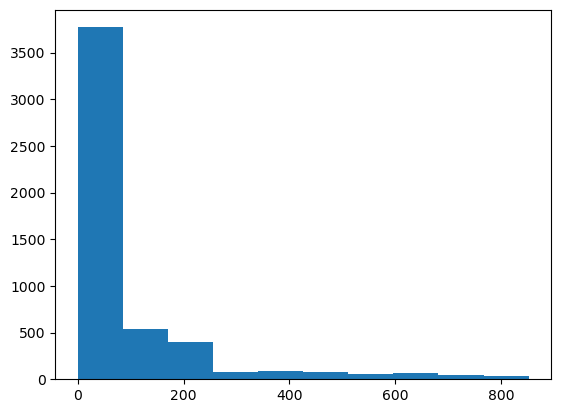

In [47]:
import matplotlib.pyplot as plt
plt.hist(len_features_human_d2)

(array([ 620., 3328., 2996., 1778.,  671.,  234.,   70.,   38.,    6.,
           9.]),
 array([ 0. ,  9.1, 18.2, 27.3, 36.4, 45.5, 54.6, 63.7, 72.8, 81.9, 91. ]),
 <BarContainer object of 10 artists>)

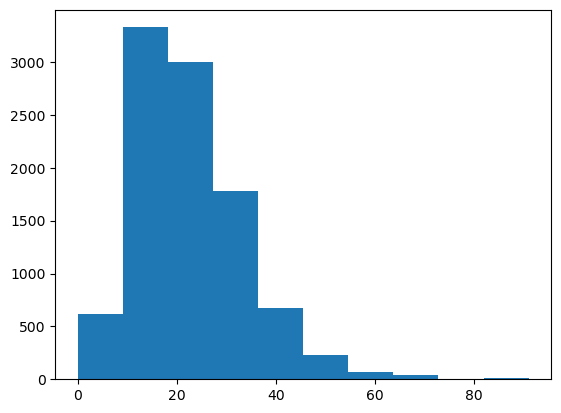

In [48]:
plt.hist(len_features_human_d1)

In [2]:
import pandas as pd
from sklearn.utils import resample

# Convert features and labels into a single DataFrame for easier handling
df = pd.DataFrame({
    'features': features_d2,
    'labels': labels_d2
})

# Separate majority and minority classes
df_majority = df[df.labels==0]
df_minority = df[df.labels==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),  # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Split the DataFrame back into features and labels
features_downsampled = df_downsampled['features'].tolist()
labels_downsampled = df_downsampled['labels'].tolist()

In [7]:
# Split the data
features = features_d1+features_d2
labels = labels_d1 + labels_d2
zeros_in_text = zeros_in_text_d1 + zeros_in_text_d2
padded_features = pad_sequences(features, padding='pre', value=0)
labels_domain = to_categorical(labels_domain, num_classes=2)



X_train, X_test, y_train, y_test, zeros_train, zeros_test,= train_test_split(
    padded_features, labels_domain, zeros_in_text,   test_size=0.2, random_state=42
)


padded_features_d1 = pad_sequences(features_d1, padding='pre', value=0)
labels_d1 = to_categorical(labels_d1, num_classes=2)
X_train_domain1, X_test_domain1, y_train_domain1, y_test_domain1, zeros_train_d1, zeros_test_d1 = train_test_split(
    padded_features_d1, labels_d1, zeros_in_text_d1, test_size=0.2, random_state=42)


padded_features_d2 = pad_sequences(features_d2, padding='pre', value=0)
labels_d2 = to_categorical(labels_d2, num_classes=2)
domains_d2 = to_categorical(domains_d2, num_classes=8)

X_train_domain2, X_test_domain2, zeros_train_d2, zeros_test_d2, y_train_domain2, y_test_domain2, y_model_train, y_model_test = train_test_split(
    padded_features_d2, zeros_in_text_d2, labels_d2,domains_d2, test_size=0.2, random_state=42, stratify=labels_d2)

y_train_d2 = {'class': y_train_domain2, 'model': y_model_train}
y_test_d2 = {'class': y_test_domain2, 'model': y_model_test}



In [21]:
from keras.models import Model
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D, Dense, Dropout, Masking, Input, Bidirectional, concatenate
from keras.regularizers import l2
import tensorflow as tf
import sys

# Constants
vocab_size = 5000  # Vocabulary size
embedding_dim = 100 # Embedding dimension
n_domain_classes = 2 # Classification for the domain task
n_classes = 2
# Input Layer
input_layer = Input(shape=(None,))
# New Input Layer for the integer feature
input_layer_integer = Input(shape=(1,)) 
# Embedding Layer
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_layer)



# Conv1D Layer
#conv1d_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding_layer)

# Dropout Layer
#dropout_conv = Dropout(0.3)(conv1d_layer)


# Max Pooling Layer
#max_pooling = MaxPooling1D(pool_size=2)(dropout_conv)

# LSTM Layer
lstm_layer = Bidirectional(LSTM(64))(embedding_layer)

# Dropout Layer
dropout_lstm = Dropout(0.3)(lstm_layer)

# Concatenate integer input with LSTM output
concat_layer = concatenate([dropout_lstm, input_layer_integer])

# New Dense Layer
dense_layer = Dense(32, activation='relu')(concat_layer)
dense_dropout = Dropout(0.3)(dense_layer)



# Domain output
domain_output = Dense(n_domain_classes, activation='sigmoid', name='domain')(dense_dropout)


# Combined model
model_domain = Model(inputs=[input_layer, input_layer_integer], outputs= domain_output)




model_domain.compile(optimizer='adam',
              loss={
                  'domain': 'binary_crossentropy'},
              metrics=['accuracy'])



# Model summary
model_domain.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, None, 100)    500000      ['input_11[0][0]']               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 128)         84480       ['embedding_5[0][0]']            
 )                                                                                                
                                                                                                  
 dropout_13 (Dropout)           (None, 128)          0           ['bidirectional_4[0][0]']  

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
zeros_train = np.array(zeros_train).reshape(-1, 1)
zeros_test = np.array(zeros_test).reshape(-1, 1)
model_domain.fit([X_train,zeros_train], y_train, validation_data=([X_test, zeros_test], y_test), epochs=50, callbacks=[early_stopping], batch_size=512)

Epoch 1/50
 7/54 [==>...........................] - ETA: 4:31 - loss: 0.6831 - accuracy: 0.4852

KeyboardInterrupt: 

In [10]:
model_domain.save("model_domain")

INFO:tensorflow:Assets written to: model_domain\assets


INFO:tensorflow:Assets written to: model_domain\assets


In [23]:
# Constants
vocab_size = 5000  # Vocabulary size
embedding_dim = 100 # Embedding dimension
n_domain_classes = 2 # Classification for the domain task

# Input Layer
input_layer = Input(shape=(None,))

input_layer_integer = Input(shape=(1,)) 
# Embedding Layer
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_layer)


# LSTM Layer
lstm_layer = Bidirectional(LSTM(64))(embedding_layer)

# Dropout Layer
dropout_lstm = Dropout(0.3)(lstm_layer)

# Concatenate integer input with LSTM output
concat_layer = concatenate([dropout_lstm, input_layer_integer])

# New Dense Layer
dense_layer = Dense(32, activation='relu')(concat_layer)
dense_dropout = Dropout(0.3)(dense_layer)


# Domain output
class_output = Dense(n_domain_classes, activation='sigmoid')(dense_dropout)

# Combined model
model_domain1 = Model(inputs=[input_layer, input_layer_integer], outputs=class_output)



model_domain1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



# Model summary
model_domain1.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, None, 100)    500000      ['input_13[0][0]']               
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 128)         84480       ['embedding_6[0][0]']            
 )                                                                                                
                                                                                                  
 dropout_15 (Dropout)           (None, 128)          0           ['bidirectional_5[0][0]']  

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
zeros_train_d1 = np.array(zeros_train_d1).reshape(-1, 1)
zeros_test_d1 = np.array(zeros_test_d1).reshape(-1, 1)
model_domain1.fit([X_train_domain1,zeros_train_d1], y_train_domain1, validation_data=([X_test_domain1,zeros_test_d1], y_test_domain1), epochs=50, callbacks=[early_stopping], batch_size = 256)

Epoch 1/50
61/61 [==============================] - 84s 1s/step - loss: 0.4575 - accuracy: 0.7776 - val_loss: 0.1958 - val_accuracy: 0.9300
Epoch 2/50
61/61 [==============================] - 72s 1s/step - loss: 0.1634 - accuracy: 0.9492 - val_loss: 0.1457 - val_accuracy: 0.9469
Epoch 3/50
61/61 [==============================] - 74s 1s/step - loss: 0.0970 - accuracy: 0.9710 - val_loss: 0.1419 - val_accuracy: 0.9479
Epoch 4/50
61/61 [==============================] - 74s 1s/step - loss: 0.0624 - accuracy: 0.9813 - val_loss: 0.1714 - val_accuracy: 0.9477
Epoch 5/50
61/61 [==============================] - 77s 1s/step - loss: 0.0426 - accuracy: 0.9872 - val_loss: 0.1771 - val_accuracy: 0.9497
Epoch 6/50
61/61 [==============================] - 74s 1s/step - loss: 0.0298 - accuracy: 0.9919 - val_loss: 0.1966 - val_accuracy: 0.9536


In [25]:
model_domain1.save("model_domain1")

INFO:tensorflow:Assets written to: model_domain1\assets


INFO:tensorflow:Assets written to: model_domain1\assets


In [ ]:
# Constants
vocab_size = 5000  # Vocabulary size
embedding_dim = 100 # Embedding dimension
n_models = 8  # Classification for the domain task
n_classes =2 
# Input Layer
input_layer = Input(shape=(None,))

# Embedding Layer
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_layer)

# Conv1D Layer
conv1d_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding_layer)

# Dropout Layer
dropout_conv = Dropout(0.3)(conv1d_layer)


# Max Pooling Layer
max_pooling = MaxPooling1D(pool_size=2)(dropout_conv)

# LSTM Layer
lstm_layer = (LSTM(64))(dropout_conv)

# Dropout Layer
dropout_lstm = Dropout(0.3)(lstm_layer)


# New Dense Layer
dense_layer = Dense(32, activation='relu')(dropout_lstm)
dense_dropout = Dropout(0.3)(dense_layer)


class_output = Dense(n_classes, activation='sigmoid', name='class')(dense_dropout)



model_output = Dense(n_models, activation='softmax', name='model')(dense_dropout)

# Combined model
model_domain2 = Model(inputs=input_layer, outputs=[class_output, model_output])




model_domain2.compile(optimizer='adam',
              loss={
                  'class': weighted_binary_crossentropy,
                  'model': 'categorical_crossentropy'},
              metrics=['accuracy'])




# Model summary
model_domain2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    500000      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, None, 64)     19264       ['embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, None, 64)     0           ['conv1d[0][0]']                 
                                                                                              

In [ ]:
len(y_train_d2["class"])

27520

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights (this is just an example; you'll need to compute this based on your own data)
class_weights = compute_class_weight('balanced', classes=[0, 1], y=np.argmax(y_train_domain2, axis=1) )  # your_labels is the array of labels in your training set
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
def weighted_binary_crossentropy(y_true, y_pred):
    weight_0 = class_weight_dict[0]
    weight_1 = class_weight_dict[1]
    
    binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
    loss = binary_crossentropy(y_true, y_pred)
    class_weights = y_true * weight_1 + (1. - y_true) * weight_0
    weighted_loss = loss * class_weights
    
    return tf.reduce_mean(weighted_loss)

In [ ]:
from tensorflow.keras.layers import concatenate

# Constants
vocab_size = 5000  # Vocabulary size
embedding_dim = 100  # Embedding dimension
n_models = 8  # Classification for the domain task
n_classes = 2  # Number of classes

# Existing Input Layer for text
input_layer_text = Input(shape=(None,))

# New Input Layer for the integer feature
input_layer_integer = Input(shape=(1,))  # Change shape as necessary

# Embedding Layer
embedding_layer = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_layer_text)

# Conv1D Layer
conv1d_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding_layer)

# Dropout Layer
dropout_conv = Dropout(0.3)(conv1d_layer)

# Max Pooling Layer
max_pooling = MaxPooling1D(pool_size=2)(dropout_conv)

# LSTM Layer
lstm_layer = LSTM(64)(dropout_conv)

# Dropout Layer
dropout_lstm = Dropout(0.3)(lstm_layer)

# Concatenate integer input with LSTM output
concat_layer = concatenate([dropout_lstm, input_layer_integer])

# New Dense Layer
dense_layer = Dense(32, activation='relu')(concat_layer)
dense_dropout = Dropout(0.3)(dense_layer)

# Class output layer
class_output = Dense(n_classes, activation='sigmoid', name='class')(dense_dropout)

# Model output layer
model_output = Dense(n_models, activation='softmax', name='model')(dense_dropout)

# Combined model
model_domain2 = Model(inputs=[input_layer_text, input_layer_integer], outputs=[class_output, model_output])

# Compile the model
model_domain2.compile(optimizer='adam',
                      loss={
                          'class': weighted_binary_crossentropy,  # Replace with your weighted loss if needed
                          'model': 'categorical_crossentropy'},
                      metrics=['accuracy'])

# Model summary
model_domain2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 100)    500000      ['input_5[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, None, 64)     19264       ['embedding_2[0][0]']            
                                                                                                  
 dropout_6 (Dropout)            (None, None, 64)     0           ['conv1d_2[0][0]']               
                                                                                            

In [ ]:
y_train_d2

{'class': array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [0., 1.]], dtype=float32),
 'model': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)}

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
zeros_train = np.array(zeros_train).reshape(-1, 1)
zeros_test = np.array(zeros_test).reshape(-1, 1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_domain2.fit([X_train_domain2,zeros_train], y_train_d2, validation_data=([X_test_domain2,zeros_test], y_test_d2), epochs=50, callbacks=[early_stopping], batch_size = 256)

Epoch 1/50
47/47 [==============================] - 11s 120ms/step - loss: 4.0402 - class_loss: 1.5027 - model_loss: 2.5375 - class_accuracy: 0.8371 - model_accuracy: 0.1579 - val_loss: 2.8997 - val_class_loss: 0.9787 - val_model_loss: 1.9210 - val_class_accuracy: 0.8557 - val_model_accuracy: 0.1980
Epoch 2/50
47/47 [==============================] - 5s 103ms/step - loss: 3.2647 - class_loss: 1.0584 - model_loss: 2.2063 - class_accuracy: 0.8467 - model_accuracy: 0.1890 - val_loss: 2.6820 - val_class_loss: 0.8013 - val_model_loss: 1.8807 - val_class_accuracy: 0.8557 - val_model_accuracy: 0.2450
Epoch 3/50
47/47 [==============================] - 5s 104ms/step - loss: 2.9043 - class_loss: 0.8961 - model_loss: 2.0082 - class_accuracy: 0.8529 - model_accuracy: 0.2292 - val_loss: 2.5725 - val_class_loss: 0.7700 - val_model_loss: 1.8025 - val_class_accuracy: 0.8560 - val_model_accuracy: 0.2668
Epoch 4/50
47/47 [==============================] - 5s 106ms/step - loss: 2.6696 - class_loss: 0.78

KeyboardInterrupt: 